## Todo
- Test 

- Preprocessing/normalization/smoothing 

- Move functions into utils file 

- Create cycle plot?! 

- Optimize hyperparameters 

- Cross validation 

In [10]:
from torch.utils.data import Dataset, random_split, DataLoader, Subset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from utils import train_and_validate, plot_single_metric, compute_mean_std, plot_train_val, plot_metric, CustomDataset
import json
import os
import numpy as np
import scipy.ndimage

## Config

In [11]:
# train params
train_size = 0.8
val_size = 0.1
test_size = 0.1
batch_size = 16
learning_rate = 0.0001
epochs = 5
patience = 100 # For early stopping

# check and select device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

#choosen_joints = ["RAnkle_x", "LAnkle_x"]
choosen_joints = ["LShoulder_x","RShoulder_y","LElbow_x","RElbow_x","LWrist_y","RWrist_x","LHip_y","RHip_x","LKnee_x","RKnee_x","LAnkle_x", "RAnkle_x"]
# "LShoulder","RShoulder","LElbow","RElbow","LWrist","RWrist","LHip","RHip","LKnee","RKnee","LAnkle","Head","Neck","LBigToe","RBigToe","LSmallToe","RSmallToe","LHeel","RHeel"

# labels
LABELS = {
    "unknown": 0,
    "gear2" : 1,
    "gear3" : 2,
    "gear4" : 3,
}

# file config
files = ["09", 
         "11", 
         #"13",
         "14_cut", 
         "15_cut", 
         #"16_cut",
         "17_cut", 
         "18_cut", 
         "19_cut", 
         "20_cut", 
         "21_cut", 
         "22_cut", 
         "23_cut",
         "25", 
         "27",
         "32",
         "33",
         "34",
         "36",
         "38", 
         "40", 
         "42",
         "43", 
         "44", 
         "53",
         "54_cut"]
file_name = "labeled_cycles_"
path = "../cycle_splits/labeled_data"

In [12]:
# # half ChatPGT generated
# class CustomDataset(Dataset):
#     def __init__(self, 
#                  files, 
#                  path, 
#                  file_name="labeled_cycles_", 
#                  choosen_joints=["RAnkle_x"],
#                  label_dict = {
#                     "unknown": 0,
#                     "gear2" : 1,
#                     "gear3" : 2,
#                     "gear4" : 3,},
#                  transform=None,
#                  target_transform=None, 
#                  padding_value=0.0,
#                  apply_gaussian_filter=True,
#                  mean=None, 
#                  std=None
#                  ):
        
#         self.label_dict = label_dict
#         self.choosen_joints = choosen_joints
#         self.padding_value = padding_value
#         self.data, self.labels = self.__load_data(files, file_name, path)
#         self.transform = transform
#         self.target_transform = target_transform
#         self.apply_gaussian_filter = apply_gaussian_filter
#         self.mean = mean
#         self.std = std

#     def __load_data(self, files, file_name, path):
#         data = []
#         labels = []
#         longest_cycle = 0  # Track longest cycle length

#         for file in files:
#             file_path = os.path.join(path, file_name + file + ".json")
#             with open(file_path, 'r') as f:
#                 data_json = json.load(f)

#             for cycle in data_json.values():
#                 # Extract joint data as (num_joints, time_steps)
#                 cycle_data = [torch.tensor(cycle[joint], dtype=torch.float32) for joint in self.choosen_joints]

#                 # Stack into a (num_joints, time_steps) tensor
#                 cycle_tensor = torch.stack(cycle_data)  # Shape: (num_joints, time_steps)
#                 longest_cycle = max(longest_cycle, cycle_tensor.shape[1])  # Update max length

#                 data.append(cycle_tensor)
#                 labels.append(cycle["Label"])

#         # Pad all cycles to match the longest cycle length
#         padded_data = []
#         for cycle in data:
#             num_joints, time_steps = cycle.shape

#             # Pad the time_steps dimension
#             pad_length = longest_cycle - time_steps
#             padded_cycle = torch.nn.functional.pad(cycle, (0, pad_length), value=self.padding_value)  # Pad last dim

#             padded_data.append(padded_cycle)

#         # Stack all padded cycles into a final tensor
#         padded_data = torch.stack(padded_data)  # Shape: (num_cycles, num_joints, max_time)

#         return padded_data, labels

#     def __len__(self):
#         return len(self.labels)

#     def __getitem__(self, idx):
        
#         label = self.label_dict[self.labels[idx]]
#         item = self.data[idx].T # Transpose for LSTM to get [max_time, num_joints]

#         if self.apply_gaussian_filter:
#             item = torch.tensor(scipy.ndimage.gaussian_filter1d(item.numpy(), sigma=2, axis=0), dtype=torch.float32)
        
#         if self.mean is not None and self.std is not None:
#             item = (item - self.mean) / self.std

#         if self.transform:
#             item = self.transform(item)

#         if self.target_transform:
#             label = self.target_transform(label)

#         return item, label

In [13]:
import torch
from torch.utils.data import Subset, DataLoader, random_split
from sklearn.model_selection import KFold

# Create initial dataset (without normalization)
train_dataset = CustomDataset(files, path, file_name, choosen_joints, padding_value=float('nan'), apply_gaussian_filter=False)

# Split into Train+Val and Test
generator = torch.Generator().manual_seed(42)
dataset_size = len(train_dataset)
train_val_size = int(dataset_size * 0.9)  # 90% for Train+Val
test_size = dataset_size - train_val_size  # 10% for Test

# Get indices for Train+Val and Test
train_val_indices, test_indices = random_split(range(dataset_size), [train_val_size, test_size], generator=generator)

# Initialize KFold (5 splits)
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

train_val_indices = list(train_val_indices)  # Convert to list
fold_loaders = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_val_indices)):
    print(f"Fold {fold+1}: Train size = {len(train_idx)}, Val size = {len(val_idx)}")
    
    # Get actual dataset indices
    train_subset_indices = [train_val_indices[i] for i in train_idx]
    val_subset_indices = [train_val_indices[i] for i in val_idx]

    # Create Subsets (before normalization)
    train_subset = Subset(train_dataset, train_subset_indices)

    # Compute mean and std from the training subset
    all_train_samples = torch.cat([train_subset[i][0] for i in range(len(train_subset))], dim=0)
    mean = all_train_samples.nanmean(dim=0)
    std = torch.std(all_train_samples[~torch.isnan(all_train_samples)])

    # Create a new dataset with computed mean/std (normalize train and val using train stats)
    normalized_dataset = CustomDataset(files, path, file_name, choosen_joints, mean=mean, std=std, apply_gaussian_filter=True)

    # Create train/val subsets on normalized dataset
    train_data = Subset(normalized_dataset, train_subset_indices)
    val_data = Subset(normalized_dataset, val_subset_indices)

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

    # Store loaders for this fold
    fold_loaders.append((train_loader, val_loader))

# Now, fold_loaders contains 5 different train/val splits while test_loader remains unchanged.
print(fold_loaders[0])


Fold 1: Train size = 230, Val size = 58
Fold 2: Train size = 230, Val size = 58
Fold 3: Train size = 230, Val size = 58
Fold 4: Train size = 231, Val size = 57
Fold 5: Train size = 231, Val size = 57
(<torch.utils.data.dataloader.DataLoader object at 0x303b2de20>, <torch.utils.data.dataloader.DataLoader object at 0x303b27f40>)


In [14]:
# # create custom dataset
# train_dataset = CustomDataset(files, path, file_name, choosen_joints, padding_value=float('nan'), apply_gaussian_filter=False)

# # split data into train, val and test set
# generator1 = torch.Generator().manual_seed(42)
# train_split = int(train_dataset.__len__() * 0.8)
# val_split = int(train_dataset.__len__() * 0.1)
# test_split = int(train_dataset.__len__() - train_split - val_split)

# print(f"Train size = {train_split}, Val size = {val_split}, Test size =  {test_split}")

# # Get train split to get mean and std
# train_indices, val_indices, test_indices = random_split(range(len(train_dataset)), 
#                                                         [train_size, val_size, test_size], 
#                                                         generator=generator1)

# train_subset = Subset(train_dataset, train_indices)


# # Compute mean and std from the training dataset
# all_train_samples = torch.cat([train_subset[i][0] for i in range(len(train_subset))], dim=0)
# mean = all_train_samples.nanmean(dim=0)
# std = torch.std(all_train_samples[~torch.isnan(all_train_samples)])

# # Create normalized datasets
# dataset = CustomDataset(files, path, file_name, choosen_joints, mean=mean, std=std, apply_gaussian_filter=True)

# # Final split
# train_data = Subset(dataset, train_indices)
# val_data = Subset(dataset, val_indices)
# test_data = Subset(dataset, test_indices)

# # create dataloader
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

1


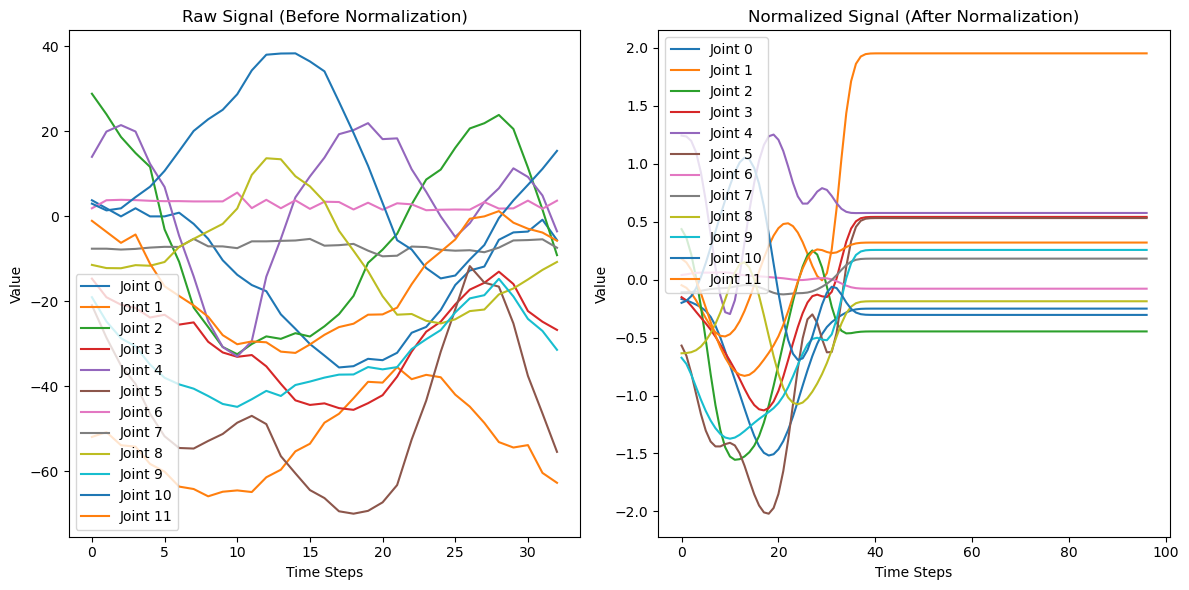

In [15]:
# Select an index to compare (e.g., the first sample in the train split)
sample_idx = train_val_indices[1]  # Ensure we use the same sample from both datasets

# Extract the raw signal (before normalization)
raw_signal, raw_label = train_dataset[sample_idx]  # From the first dataset instance

# Extract the processed signal (after normalization)
normalized_signal, norm_label = normalized_dataset[sample_idx]  # From the second dataset instance

# Ensure labels match
assert raw_label == norm_label, "Labels should match between datasets"

# Plot the signals for each joint
print(raw_label)
plt.figure(figsize=(12, 6))

for i in range(raw_signal.shape[1]):  # Iterate over each joint
    plt.subplot(1, 2, 1)
    plt.plot(raw_signal[:, i], label=f'Joint {i}')
    plt.title("Raw Signal (Before Normalization)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(normalized_signal[:, i], label=f'Joint {i}')
    plt.title("Normalized Signal (After Normalization)")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.legend()

plt.tight_layout()
plt.show()


In [16]:
class LSTMNet(nn.Module):
    def __init__(self, input_channels, hidden_size, output, num_layers, dropout):
        super(LSTMNet, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_channels, hidden_size, num_layers, batch_first=True)
        
        # Output layer (fully connected layer after LSTM)
        self.fc = nn.Linear(hidden_size, output)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # Initialize hidden state and cell state for LSTM
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward pass
        output, (hn, cn) = self.lstm(x, (h0, c0))
        output = self.dropout(output[:, -1, :])
        
        output = self.fc(output)  # (batch_size, output_size)
        
        return output


In [17]:
input_channels = train_dataset[0][0].shape[1] # Input size is the amount of joints
hidden_size = 256
num_layers = 2
dropout = 0.2
output = len(set(train_dataset.labels))
net = LSTMNet(input_channels=input_channels, 
            hidden_size=hidden_size, 
            output=output, 
            num_layers=num_layers, 
            dropout=dropout,
            )
net


LSTMNet(
  (lstm): LSTM(12, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

## Training the Neural Net

In [18]:
seeds = [42, 7, 13, 67, 89]
all_results = []
best_train_cms = []
best_val_cms = []


for fold, (train_loader, val_loader) in enumerate(fold_loaders):
    print(f"\n>>> Training on Fold {fold+1} <<<\n")
    
    # Initialize a new model for each fold
    for seed in seeds:
        print(f"\n========== Running for Seed {seed} on Fold {fold+1} ==========\n")
        
        # Set seed for reproducibility
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


        net = LSTMNet(input_channels=input_channels, 
                      hidden_size=hidden_size, 
                      output=output, 
                      num_layers=num_layers, 
                      dropout=dropout)
        net.to(device)

        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)

        # Train and validate
        results, best_train_cm, best_val_cm = train_and_validate(seed, 
                                                                 net, 
                                                                 criterion, 
                                                                 optimizer,
                                                                 epochs,
                                                                 learning_rate,
                                                                 patience,
                                                                 train_loader,
                                                                 val_loader,
                                                                 device
                                                                 )
        
        # Store results
        all_results.append({'seed': seed, 'fold': fold+1, 'results': results})
        best_train_cms.append({'seed': seed, 'fold': fold+1, 'cm': best_train_cm})
        best_val_cms.append({'seed': seed, 'fold': fold+1, 'cm': best_val_cm})



>>> Training on Fold 1

========== Running for Seed 42 on Fold 1 ==========

Training
Epoch: 1/5, Loss: 1.382, Accuracy: 29.130
Validation
Epoch: 1/5, Loss: 1.338, Accuracy: 63.793
Model saved at epoch 1
Training
Epoch: 2/5, Loss: 1.291, Accuracy: 58.696
Validation
Epoch: 2/5, Loss: 1.205, Accuracy: 63.793
Model saved at epoch 2
Training
Epoch: 3/5, Loss: 1.130, Accuracy: 58.696
Validation
Epoch: 3/5, Loss: 0.988, Accuracy: 63.793
Model saved at epoch 3
Training
Epoch: 4/5, Loss: 1.072, Accuracy: 58.696
Validation
Epoch: 4/5, Loss: 0.996, Accuracy: 63.793
Training
Epoch: 5/5, Loss: 1.064, Accuracy: 58.696
Validation
Epoch: 5/5, Loss: 0.982, Accuracy: 63.793
Model saved at epoch 5
Finished Training

========== Running for Seed 7 on Fold 1 ==========

Training
Epoch: 1/5, Loss: 1.348, Accuracy: 43.913
Validation
Epoch: 1/5, Loss: 1.304, Accuracy: 63.793
Model saved at epoch 1
Training
Epoch: 2/5, Loss: 1.254, Accuracy: 58.696
Validation
Epoch: 2/5, Loss: 1.160, Accuracy: 63.793
Model sa

In [19]:
# seeds = [42, 7, 13, 67, 89]
# all_results = []
# best_train_cms = []
# best_val_cms = []
# for seed in seeds:
#     net = LSTMNet(input_channels=input_channels, 
#                   hidden_size=hidden_size, 
#                   output=output, 
#                   num_layers=num_layers, 
#                   dropout=dropout,
#                   )
#     net.to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#     results, best_train_cm, best_val_cm = train_and_validate(seed, 
#                                                              net, 
#                                                              criterion, 
#                                                              optimizer,
#                                                              epochs,
#                                                              learning_rate,
#                                                              patience,
#                                                              train_loader,
#                                                              val_loader,
#                                                              device
#                                                              )
#     all_results.append(results)
#     best_train_cms.append(best_train_cm)
#     best_val_cms.append(best_val_cm)

# Plots

In [20]:
# ChatGPT base code for plots
# Extract metrics
metrics = ["losses", "accs", "precisions", "recalls", "f1s"]
mean_std_results = {metric: {
    "train": compute_mean_std(all_results, f"train_{metric}"),
    "val": compute_mean_std(all_results, f"val_{metric}")
} for metric in metrics}

# Plot combined graphs
plot_train_val(all_results, "losses", "Train vs Validation Loss", "Loss", mean_std_results)
plot_train_val(all_results, "accs", "Train vs Validation Accuracy", "Accuracy (%)", mean_std_results)
plot_train_val(all_results, "f1s", "Train vs Validation F1-Score", "F1 Score", mean_std_results)


KeyError: 'train_losses'

In [ ]:
epochs = len(all_results[0]["train_losses"])  # Assuming all have same number of epochs
x = np.arange(1, epochs + 1)  # X-axis values (Epochs)
metrics = ["train_losses", "train_accs", "train_precisions", "train_recalls", "train_f1s",
           "val_losses", "val_accs", "val_precisions", "val_recalls", "val_f1s"]
mean_std_results = {metric: compute_mean_std(all_results, metric) for metric in metrics}

# Plot training loss
plot_metric("train_losses", "Training Loss Over Epochs", x, "Loss", mean_std_results)

# Plot validation loss
plot_metric("val_losses", "Validation Loss Over Epochs", x, "Loss", mean_std_results)

# Plot accuracy
plot_metric("train_accs", "Training Accuracy Over Epochs", x, "Accuracy (%)", mean_std_results)
plot_metric("val_accs", "Validation Accuracy Over Epochs", x, "Accuracy (%)", mean_std_results)

# Plot F1-score
plot_metric("train_f1s", "Training F1-Score Over Epochs", x, "F1 Score", mean_std_results)
plot_metric("val_f1s", "Validation F1-Score Over Epochs", x, "F1 Score", mean_std_results)

In [ ]:
for i, results in enumerate(all_results):    
    epochs_trained = len(results["train_losses"])
    epoch_range = range(1, epochs_trained + 1)

    print("_"*100)
    print(f"Results for seed {seeds[i]}")

    plt.figure(figsize=(15, 12))

    # Plotting training and validation loss
    plt.subplot(2, 3, 1)
    plot_single_metric(epoch_range, results["train_losses"], results["val_losses"], 'Loss', 'Epoch', 'Loss')

    # Plotting training and validation accuracy
    plt.subplot(2, 3, 2)
    plot_single_metric(epoch_range, results["train_accs"], results["val_accs"], 'Accuracy', 'Epoch', 'Accuracy (%)')

    # Plotting training and validation precision
    plt.subplot(2, 3, 3)
    plot_single_metric(epoch_range, results["train_precisions"], results["val_precisions"], 'Precision', 'Epoch', 'Precision')

    # Plotting training and validation recall
    plt.subplot(2, 3, 4)
    plot_single_metric(epoch_range, results["train_recalls"], results["val_recalls"], 'Recall', 'Epoch', 'Recall')

    # Plotting training and validation F1 scores
    plt.subplot(2, 3, 5)
    plot_single_metric(epoch_range, results["train_f1s"], results["val_f1s"], 'F1 Score', 'Epoch', 'F1 Score')

    plt.tight_layout()
    plt.show()

    disp_train_cm = ConfusionMatrixDisplay(best_train_cms[i], display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
    disp_train_cm.plot()
    plt.title(f"Seed {seeds[i]} training lowest val loss confusion matrix")
    plt.show()

    disp_val_cm = ConfusionMatrixDisplay(best_val_cms[i], display_labels=list(LABELS.keys())[:len(set(dataset.labels))])
    disp_val_cm.plot()
    plt.title(f"Seed {seeds[i]} validation lowest val loss confusion matrix")
    plt.show()



In [ ]:
# Define colors for different seeds
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more if needed

plt.figure(figsize=(15, 12))

# Metric names and corresponding keys in the results dictionary
metrics = {
    "Loss": ("train_losses", "val_losses"),
    "Accuracy": ("train_accs", "val_accs"),
    "Precision": ("train_precisions", "val_precisions"),
    "Recall": ("train_recalls", "val_recalls"),
    "F1 Score": ("train_f1s", "val_f1s"),
}

# Iterate over each metric and create a subplot for it
for idx, (metric_name, (train_key, val_key)) in enumerate(metrics.items(), 1):
    plt.subplot(2, 3, idx)  # Arrange plots in a 2x3 grid
    
    for i, results in enumerate(all_results):
        epochs_trained = len(results[train_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]  # Assign a color

        # Plot training metric
        plt.plot(epoch_range, results[train_key], label=f'Training Seed {seeds[i]}', linestyle='--', color=color)
        # Plot validation metric
        plt.plot(epoch_range, results[val_key], label=f'Validation Seed {seeds[i]}', linestyle='-', color=color)

    plt.title(f'Training & Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Define colors for different seeds
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Add more if needed

plt.figure(figsize=(15, 20))  # Larger figure to fit 10 subplots

# Metric names and corresponding keys in the results dictionary
metrics = {
    "Loss": ("train_losses", "val_losses"),
    "Accuracy": ("train_accs", "val_accs"),
    "Precision": ("train_precisions", "val_precisions"),
    "Recall": ("train_recalls", "val_recalls"),
    "F1 Score": ("train_f1s", "val_f1s"),
}

# Iterate over each metric and create subplots
for idx, (metric_name, (train_key, val_key)) in enumerate(metrics.items()):
    
    # Training Plot
    plt.subplot(5, 2, 2 * idx + 1)  # Left column for training
    for i, results in enumerate(all_results):
        epochs_trained = len(results[train_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]
        
        plt.plot(epoch_range, results[train_key], label=f'Seed {seeds[i]}', color=color)
    
    plt.title(f'Training {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

    # Validation Plot
    plt.subplot(5, 2, 2 * idx + 2)  # Right column for validation
    for i, results in enumerate(all_results):
        epochs_trained = len(results[val_key])
        epoch_range = range(1, epochs_trained + 1)
        color = colors[i % len(colors)]
        
        plt.plot(epoch_range, results[val_key], label=f'Seed {seeds[i]}', color=color)
    
    plt.title(f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()

plt.tight_layout()
plt.show()
